## Imports & Setup

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip
from helpers import *

In [2]:
torch.manual_seed(110)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Prepare Dataset

In [4]:
size = 64
batch_size = 1
epsilon_images = []
transformation = Compose([RandomHorizontalFlip(), Resize((size, size)), ToTensor()])

In [5]:
# only training dataset will be noised
root = 'chest_xray/train'
train_data = create_dataset(root, transformation)
data_loader = produce_loader(train_data, batch_size)

In [6]:
root = 'chest_xray/test'
test_data = create_dataset(root, transformation)

In [7]:
root = 'chest_xray/val'
val_data = create_dataset(root, transformation)

In [8]:
# take entire dataset only for the purpose of computing mean and standard deviation
entire_dataset = torch.utils.data.ConcatDataset([ train_data, test_data, val_data ])
full_loader = produce_loader(entire_dataset, 256)

In [9]:
# Compute mean and standard deviation
mean = 0
std = 0
total_samples = 0
for imgs, _ in full_loader:
    samples = imgs.size(0)
    imgs = imgs.view(samples, imgs.size(1), -1)
    mean += imgs.mean(2).sum(0)
    std += imgs.std(2).sum(0)
    total_samples += samples
    
mean /= total_samples
std /= total_samples

print('Mean:', mean)
print('Std:', std)

Mean: tensor([0.4814, 0.4814, 0.4814])
Std: tensor([0.2186, 0.2186, 0.2186])


[3272, 3101, 4122, 3751, 3948, 1758, 416, 794, 2798]


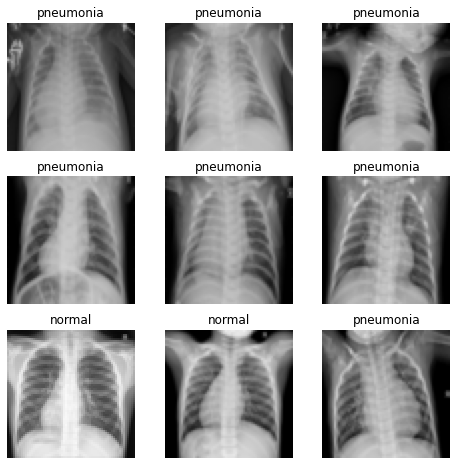

In [10]:
visualize_data(train_data)

## Produce Epsilon Images

In [11]:
def generate_epsilon_image(device, image, epsilon=0.03):
    
    # Generate noise matrix, with same shape as image,
    # and random values in [- epsilon, epsilon]
    img_rows = image.shape[-2]
    img_cols = image.shape[-1]
    epsilon_mat = (torch.rand(3, img_cols, img_rows, device=device) - 0.5) * 2 * epsilon
    
    # Create the attack image by adjusting each pixel of the input image
    eps_image = image + epsilon_mat
    eps_image = eps_image.float()
    eps_image = torch.clamp(eps_image, 0, 1)
    return eps_image

In [12]:
for image, label in data_loader:
    # Noise only NORMAL (label 0) images, as there are fewer samples in the dataset
    if label.item()==0:
        image = image.to(device)
        eps_image = generate_epsilon_image(device, image)
        eps_image = torch.squeeze(eps_image, 0)
        epsilon_images.append(eps_image)

In [13]:
for i in range(len(epsilon_images)):
    epsilon_images[i] = epsilon_images[i].cpu().detach().numpy()

## View Epsilon Images

In [14]:
def see_epsilon_images(dataset, figsize=(12,12), axes=5):
    indices = []
    cols, rows = axes, axes
    figure = plt.figure(figsize=figsize)
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        indices.append(sample_idx)
        img = dataset[sample_idx]
        img = img.swapaxes(0,1)
        img = img.swapaxes(1,2)
        figure.add_subplot(rows, cols, i)
        plt.axis("off")
        plt.imshow(img)
    print(indices)
    indices = []
    plt.show()

[526, 169, 925, 110, 935, 115, 463, 269, 1201, 673, 291, 106, 981, 816, 24, 846, 655, 1129, 238, 969, 530, 703, 1123, 447, 227]


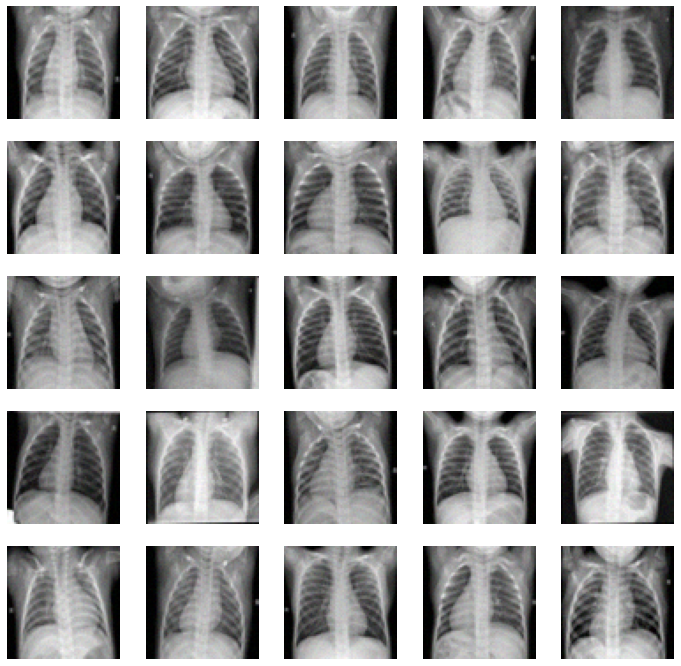

In [16]:
# Check that images are plausible
see_epsilon_images(epsilon_images)

## Save Epsilon Images

In [18]:
# Save new images, their mean and std should follow
# a similar enough distribution as calculated above
counter = 0
for item in epsilon_images:
    item = item.swapaxes(0,1)
    item = item.swapaxes(1,2)
    plt.imsave(f'./chest_xray/train/NORMAL/epsilon_image{counter}.jpg', item)
    counter += 1